In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras 
import matplotlib.pyplot as plt 
import sys 
sys.path.append('../') 
from layer_approx_utils import *

In [16]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [43]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
test_images = np.expand_dims(test_images.astype("float32")/255.0,-1)
test_labels = test_labels.astype("float32")
train_images = np.expand_dims(train_images.astype("float32")/255.0,-1)
train_labels = train_labels.astype("float32")
val_images = train_images[-10000:]
val_labels = train_labels[-10000:]
train_images = train_images[:-10000]
train_labels = train_labels[:-10000]
# random shuffling is very very important ...
np.random.seed(8)
ind = np.random.choice(train_images.shape[0], train_images.shape[0], replace=False)
train_images = train_images[ind, :]
train_labels = train_labels[ind]

train_images = train_images[:512]
train_labels = train_labels[:512]

In [44]:
loadedModel = keras.models.load_model('Lenet_Mnist_Run2')
origLoss, origAccuracy = loadedModel.evaluate(test_images, test_labels, batch_size=128)
loadedModel.summary()
initial_size = 6*5*5*1 + 6  + 16*5*5*6 + 16 + 256*120 + 120 + 120*84 + 84 + 84*10 + 10

79/79 [==============================] - 0s 1ms/step - loss: 0.4341 - sparse_categorical_accuracy: 0.8698
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 24, 24, 6)         156       
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 12, 12, 6)         0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 8, 8, 16)          2416      
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               30840     
________________

In [45]:
class sparseLayerlocal(keras.layers.Layer):
    def __init__(self, n_input=None, n_output=None, Wip=None, Mip=None, bias_ip=None):
        
        super(sparseLayerlocal, self).__init__()
        
        if Wip is None:
            w_init = tf.random_normal_initializer()
            self.W = tf.Variable(initial_value=w_init(shape=(n_input,n_output)),
                                dtype="float32",
                                trainable=True)
        else:
            self.W = tf.Variable(initial_value=Wip, 
                                dtype="float32",
                                trainable=True)
                    
        if Mip is None:
            self.M = tf.Variable(intial_value = tf.ones(shape=(n_input,n_output), dtype="float32"),
                                     dtype="float32",
                                     trainable=False)
        else:
            self.M = tf.Variable(initial_value = Mip,
                                 dtype="float32",
                                 trainable=False)
        
        if bias_ip is None:
            b_init = tf.zeros_initializer()
            self.b = tf.Variable(initial_value=b_init(shape=(n_output,)), 
                             dtype="float32", 
                             trainable=True)
        else:
            self.b = tf.Variable(initial_value=bias_ip, 
                             dtype="float32", 
                             trainable=True)
            
    def call(self, x):
        x = tf.matmul(x, tf.multiply(self.M, self.W)) + self.b
        return tf.nn.relu(x)

In [46]:
#DLR Layer 1
U_dict_layer1 = np.load('approx_matrices/DLR_layer_1_Run2_N_512.npy',allow_pickle=True).item()
thr = 0.5
acc_DLR = []
acc_DLR_finetuned = []
ranks = []
idx = 5
for epsilon, W in U_dict_layer1.items():

    [U,S,V] = np.linalg.svd(W)
    #print(S)
    rank = np.count_nonzero(S>thr)
    U = np.dot(U[:,:rank], np.diag(S[:rank]))
    V = V[:rank, :]
  
                            
    ranks.append(rank)
                            
    loadedModel = keras.models.load_model('Lenet_Mnist_Run2')
    bias = getLayerBias(loadedModel, idx)
    
    low_rank_layer = lowrankLayer(W.shape[0], W.shape[1], rank)
    dum = low_rank_layer(tf.ones(shape=(1, W.shape[0])))     # for proper initialization   
    low_rank_layer.set_weights([U,V,bias])
                      
    new_layer_list = [keras.Input(shape=(28,28,1))]
    for i,layer in enumerate(loadedModel.layers):
        if i == idx:
            new_layer_list.append(low_rank_layer)
        else:
            #layer.trainable = False
            new_layer_list.append(layer)
                            
    LenetModel_Approx = keras.Sequential(new_layer_list)
    LenetModel_Approx.compile(optimizer=keras.optimizers.Adam(learning_rate = 1e-3), 
                   loss=keras.losses.SparseCategoricalCrossentropy(), 
                   metrics=[keras.metrics.SparseCategoricalAccuracy()])
    
    loss, acc = LenetModel_Approx.evaluate(test_images, test_labels, batch_size=128)
    acc_DLR.append(acc)
                            
    LenetModel_Approx.fit(train_images, train_labels, batch_size=64, epochs=1, validation_data=(val_images, val_labels))
    loss, acc = LenetModel_Approx.evaluate(test_images, test_labels, batch_size=128)
    acc_DLR_finetuned.append(acc)     

acc_DLR_layer1 = np.array(acc_DLR)
acc_DLR_finetuned_layer1 = np.array(acc_DLR_finetuned)
ranks_layer1 = np.array(ranks)

79/79 [==============================] - 0s 1ms/step - loss: 0.6513 - sparse_categorical_accuracy: 0.7765


In [47]:
ranks_layer1

array([75, 58, 37, 24, 18, 15, 12, 10, 10,  8,  6])

In [48]:
size_with_layer_1 = []
for rank in ranks_layer1:
    size =  6*5*5*1 + 6  + 16*5*5*6 + 16 +  (256 + 120)*rank + 120 +  120*84 + 84 +  84*10 +10
    size_with_layer_1.append(size)

In [49]:
# LR layer 1
acc_LR = []
acc_LR_finetuned = []
idx = 5
for rank in ranks_layer1:
    
    loadedModel = keras.models.load_model('Lenet_Mnist_Run2')
    W = loadedModel.get_layer(index=idx).get_weights()[0]
    bias  = loadedModel.get_layer(index=idx).get_weights()[1]
    
    [U,S,V] = np.linalg.svd(W)
    U = np.dot(U[:,:rank], np.diag(S[:rank]))
    V = V[:rank, :]
                            
    low_rank_layer = lowrankLayer(W.shape[0], W.shape[1], rank)
    dum = low_rank_layer(tf.ones(shape=(1, W.shape[0])))     # for proper initialization   
    low_rank_layer.set_weights([U,V,bias])
                      
    new_layer_list = [keras.Input(shape=(28,28,1))]
    for i,layer in enumerate(loadedModel.layers):
        if i == idx:
            new_layer_list.append(low_rank_layer)
        else:
            #layer.trainable = False
            new_layer_list.append(layer)
                            
    LenetModel_Approx = keras.Sequential(new_layer_list)
    LenetModel_Approx.compile(optimizer=keras.optimizers.Adam(learning_rate = 1e-3), 
                   loss=keras.losses.SparseCategoricalCrossentropy(), 
                   metrics=[keras.metrics.SparseCategoricalAccuracy()])
    
    loss, acc = LenetModel_Approx.evaluate(test_images, test_labels, batch_size=128)
    acc_LR.append(acc)
                            
    LenetModel_Approx.fit(train_images, train_labels, batch_size=64, epochs=2, validation_data=(val_images, val_labels))
    loss, acc = LenetModel_Approx.evaluate(test_images, test_labels, batch_size=128)
    acc_LR_finetuned.append(acc)     

acc_LR_layer1 = np.array(acc_LR)
acc_LR_finetuned_layer1 = np.array(acc_LR_finetuned)


79/79 [==============================] - 0s 1ms/step - loss: 0.5373 - sparse_categorical_accuracy: 0.8359
Epoch 1/2
8/8 [==============================] - 0s 26ms/step - loss: 0.3550 - sparse_categorical_accuracy: 0.8789 - val_loss: 0.4226 - val_sparse_categorical_accuracy: 0.8740
Epoch 2/2
79/79 [==============================] - 0s 1ms/step - loss: 0.5316 - sparse_categorical_accuracy: 0.8379
Epoch 1/2
8/8 [==============================] - 0s 27ms/step - loss: 0.3754 - sparse_categorical_accuracy: 0.8711 - val_loss: 0.5110 - val_sparse_categorical_accuracy: 0.8454
Epoch 2/2
79/79 [==============================] - 0s 1ms/step - loss: 0.5585 - sparse_categorical_accuracy: 0.8267
Epoch 1/2
8/8 [==============================] - 0s 25ms/step - loss: 0.3713 - sparse_categorical_accuracy: 0.8848 - val_loss: 0.4393 - val_sparse_categorical_accuracy: 0.8643
Epoch 2/2
79/79 [==============================] - 0s 1ms/step - loss: 0.7608 - sparse_categorical_accuracy: 0.7470
Epoch 1/2
8/8 [===

In [50]:
#nettrim Layer 1
U_dict_layer1 = np.load('approx_matrices/net_trim_layer_1_Run2_N_512.npy', allow_pickle=True).item()
thr = 0.0001
acc_nettrim = []
acc_nettrim_finetuned = []
nnzs = []
idx = 5
for epsilon, W in U_dict_layer1.items():
    
    W[np.abs(W)<=thr] = 0.0
    M = np.ones_like(W, dtype="float32")
    M[np.abs(W)<=thr] = 0.0
    W = W.astype("float32")
    M = M.astype("float32")
    nnz = np.count_nonzero(W)
    nnzs.append(nnz)
                            
        
    loadedModel = keras.models.load_model('Lenet_Mnist_Run2')
    bias = getLayerBias(loadedModel, idx)
    
    sparseLayer = sparseLayerlocal(n_input=W.shape[0], n_output=W.shape[1], Wip=W, Mip=M, bias_ip=bias)
                      
    new_layer_list = [keras.Input(shape=(28,28,1))]
    for i,layer in enumerate(loadedModel.layers):
        if i == idx:
            new_layer_list.append(sparseLayer)
        else:
            #layer.trainable = False
            new_layer_list.append(layer)
                            
    LenetModel_Approx = keras.Sequential(new_layer_list)
    LenetModel_Approx.compile(optimizer=keras.optimizers.Adam(learning_rate = 1e-3), 
                   loss=keras.losses.SparseCategoricalCrossentropy(), 
                   metrics=[keras.metrics.SparseCategoricalAccuracy()])
    
    loss, acc = LenetModel_Approx.evaluate(test_images, test_labels, batch_size=128)
    acc_nettrim.append(acc)
                            
    LenetModel_Approx.fit(train_images, train_labels, batch_size=64, epochs=1, validation_data=(val_images, val_labels))
    loss, acc = LenetModel_Approx.evaluate(test_images, test_labels, batch_size=128)
    acc_nettrim_finetuned.append(acc)     

acc_nettrim_layer1 = np.array(acc_nettrim)
acc_netrim_finetuned_layer1 = np.array(acc_nettrim_finetuned)
nnz_layer1 = np.array(nnzs)

79/79 [==============================] - 0s 1ms/step - loss: 0.5982 - sparse_categorical_accuracy: 0.8095


In [51]:
nettrimm_size_with_layer_1 = []
for nnz in nnz_layer1:
    size =  6*5*5*1 + 6  + 16*5*5*6 + 16 +  3*nnz  + 120 +  120*84 + 84 +  84*10 +10
    nettrimm_size_with_layer_1.append(size)

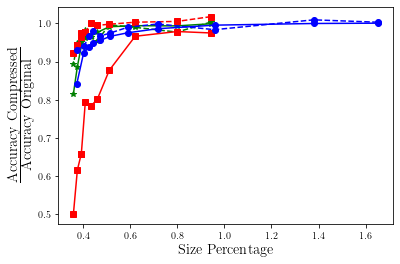

In [52]:
plt.rcParams.update({"text.usetex": True})
plt.plot(np.array(size_with_layer_1)/initial_size, acc_DLR_layer1/origAccuracy, 'g-*' )
plt.plot(np.array(size_with_layer_1)/initial_size, acc_DLR_finetuned_layer1/origAccuracy, 'g--*' )

plt.plot(np.array(size_with_layer_1)/initial_size, acc_LR_layer1/origAccuracy, 'r-s' )
plt.plot(np.array(size_with_layer_1)/initial_size, acc_LR_finetuned_layer1/origAccuracy, 'r--s' )

plt.plot(np.array(nettrimm_size_with_layer_1)/initial_size, acc_nettrim_layer1/origAccuracy, 'b-o' )
plt.plot(np.array(nettrimm_size_with_layer_1)/initial_size, acc_netrim_finetuned_layer1/origAccuracy, 'b--o' )

plt.xlabel(r'$\textrm{Size Percentage}$', fontsize='x-large')
plt.ylabel(r'$\frac{\textrm{Accuracy Compressed}}{\textrm{Accuracy Original}}$',fontsize='x-large') 
plt.savefig('Figures/MNIST_layer1_Ntr_512_N_approx_512_full_finetune.pdf')

In [53]:
# DLR layer 2
U_dict_layer2 = np.load('approx_matrices/DLR_layer_2_Run2_N_512.npy',allow_pickle=True).item()
thr = 0.1
acc_DLR = []
acc_DLR_finetuned = []
ranks = []
idx = 6
for epsilon, W in U_dict_layer2.items():

    [U, S, V] = np.linalg.svd(W)
    #print(S)
    rank = np.count_nonzero(S>thr)
    U = np.dot(U[:,:rank], np.diag(S[:rank]))
    V = V[:rank, :]
                            
    ranks.append(rank)
                            
    loadedModel = keras.models.load_model('Lenet_Mnist_Run2')
    bias = getLayerBias(loadedModel, idx)
    
    low_rank_layer = lowrankLayer(W.shape[0], W.shape[1], rank)
    dum = low_rank_layer(tf.ones(shape=(1, W.shape[0])))     # for proper initialization   
    low_rank_layer.set_weights([U,V,bias])
                      
    new_layer_list = [keras.Input(shape=(28,28,1))]
    for i,layer in enumerate(loadedModel.layers):
        if i == idx:
            new_layer_list.append(low_rank_layer)
        else:
            #layer.trainable = False
            new_layer_list.append(layer)
                            
    LenetModel_Approx = keras.Sequential(new_layer_list)
    LenetModel_Approx.compile(optimizer=keras.optimizers.Adam(learning_rate = 1e-3), 
                   loss=keras.losses.SparseCategoricalCrossentropy(), 
                   metrics=[keras.metrics.SparseCategoricalAccuracy()])
    
    loss, acc = LenetModel_Approx.evaluate(test_images, test_labels, batch_size=128)
    acc_DLR.append(acc)
                            
    LenetModel_Approx.fit(train_images, train_labels, batch_size=64, epochs=1, validation_data=(val_images, val_labels))
    loss, acc = LenetModel_Approx.evaluate(test_images, test_labels, batch_size=128)
    acc_DLR_finetuned.append(acc)     

acc_DLR_layer2 = np.array(acc_DLR)
acc_DLR_finetuned_layer2 = np.array(acc_DLR_finetuned)
ranks_layer2 = np.array(ranks)

79/79 [==============================] - 0s 1ms/step - loss: 0.6340 - sparse_categorical_accuracy: 0.7965


In [54]:
ranks_layer2

array([56, 46, 26, 17, 14, 11, 10,  9,  9,  8,  6])

In [55]:
size_with_layer_2 = []
for rank in ranks_layer2:
    size =  6*5*5*1 + 6  + 16*5*5*6 + 16 +  256*120 + 120 +  (120+84)*rank + 84 +  84*10 +10
    size_with_layer_2.append(size)

In [56]:
# LR layer 2
acc_LR = []
acc_LR_finetuned = []
idx = 6
for rank in ranks_layer2:
    
    loadedModel = keras.models.load_model('Lenet_Mnist_Run2')
    W = loadedModel.get_layer(index=idx).get_weights()[0]
    bias  = loadedModel.get_layer(index=idx).get_weights()[1]
    
    [U,S,V] = np.linalg.svd(W)
    U = np.dot(U[:,:rank], np.diag(S[:rank]))
    V = V[:rank, :]
                            
    low_rank_layer = lowrankLayer(W.shape[0], W.shape[1], rank)
    dum = low_rank_layer(tf.ones(shape=(1, W.shape[0])))     # for proper initialization   
    low_rank_layer.set_weights([U,V,bias])
                      
    new_layer_list = [keras.Input(shape=(28,28,1))]
    for i,layer in enumerate(loadedModel.layers):
        if i == idx:
            new_layer_list.append(low_rank_layer)
        else:
            #layer.trainable = False
            new_layer_list.append(layer)
                            
    LenetModel_Approx = keras.Sequential(new_layer_list)
    LenetModel_Approx.compile(optimizer=keras.optimizers.Adam(learning_rate = 1e-3), 
                   loss=keras.losses.SparseCategoricalCrossentropy(), 
                   metrics=[keras.metrics.SparseCategoricalAccuracy()])
    
    loss, acc = LenetModel_Approx.evaluate(test_images, test_labels, batch_size=128)
    acc_LR.append(acc)
                            
    LenetModel_Approx.fit(train_images, train_labels, batch_size=64, epochs=2, validation_data=(val_images, val_labels))
    loss, acc = LenetModel_Approx.evaluate(test_images, test_labels, batch_size=128)
    acc_LR_finetuned.append(acc)     

acc_LR_layer2 = np.array(acc_LR)
acc_LR_finetuned_layer2 = np.array(acc_LR_finetuned)

79/79 [==============================] - 0s 1ms/step - loss: 0.5586 - sparse_categorical_accuracy: 0.8274
Epoch 1/2
8/8 [==============================] - 0s 25ms/step - loss: 0.3538 - sparse_categorical_accuracy: 0.8691 - val_loss: 0.4262 - val_sparse_categorical_accuracy: 0.8746
Epoch 2/2
79/79 [==============================] - 0s 1ms/step - loss: 0.6848 - sparse_categorical_accuracy: 0.7853
Epoch 1/2
8/8 [==============================] - 0s 25ms/step - loss: 0.4298 - sparse_categorical_accuracy: 0.8652 - val_loss: 0.4633 - val_sparse_categorical_accuracy: 0.8514
Epoch 2/2
79/79 [==============================] - 0s 1ms/step - loss: 0.8567 - sparse_categorical_accuracy: 0.7312
Epoch 1/2
8/8 [==============================] - 0s 25ms/step - loss: 0.5341 - sparse_categorical_accuracy: 0.8359 - val_loss: 0.6361 - val_sparse_categorical_accuracy: 0.7992
Epoch 2/2
79/79 [==============================] - 0s 1ms/step - loss: 1.6395 - sparse_categorical_accuracy: 0.4506
Epoch 1/2
8/8 [===

In [57]:
#nettrim Layer 2
U_dict_layer2 = np.load('approx_matrices/net_trim_layer_2_Run2_N_512.npy', allow_pickle=True).item()
thr = 0.0001
acc_nettrim = []
acc_nettrim_finetuned = []
nnzs = []
idx = 6
for epsilon, W in U_dict_layer2.items():
    
    W[np.abs(W)<=thr] = 0.0
    M = np.ones_like(W, dtype="float32")
    M[np.abs(W)<=thr] = 0.0
    W = W.astype("float32")
    M = M.astype("float32")
    nnz = np.count_nonzero(W)
    nnzs.append(nnz)
                            
        
    loadedModel = keras.models.load_model('Lenet_Mnist_Run2')
    bias = getLayerBias(loadedModel, idx)
    
    sparseLayer = sparseLayerlocal(n_input=W.shape[0], n_output=W.shape[1], Wip=W, Mip=M, bias_ip=bias)
                      
    new_layer_list = [keras.Input(shape=(28,28,1))]
    for i,layer in enumerate(loadedModel.layers):
        if i == idx:
            new_layer_list.append(sparseLayer)
        else:
            #layer.trainable = False
            new_layer_list.append(layer)
                            
    LenetModel_Approx = keras.Sequential(new_layer_list)
    LenetModel_Approx.compile(optimizer=keras.optimizers.Adam(learning_rate = 1e-3), 
                   loss=keras.losses.SparseCategoricalCrossentropy(), 
                   metrics=[keras.metrics.SparseCategoricalAccuracy()])
    
    loss, acc = LenetModel_Approx.evaluate(test_images, test_labels, batch_size=128)
    acc_nettrim.append(acc)
                            
    LenetModel_Approx.fit(train_images, train_labels, batch_size=64, epochs=1, validation_data=(val_images, val_labels))
    loss, acc = LenetModel_Approx.evaluate(test_images, test_labels, batch_size=128)
    acc_nettrim_finetuned.append(acc)     

acc_nettrim_layer2 = np.array(acc_nettrim)
acc_netrim_finetuned_layer2 = np.array(acc_nettrim_finetuned)
nnz_layer2 = np.array(nnzs)

79/79 [==============================] - 0s 1ms/step - loss: 0.5643 - sparse_categorical_accuracy: 0.8216


In [58]:
nettrimm_size_with_layer_2 = []
for nnz in nnz_layer2:
    size =  6*5*5*1 + 6  + 16*5*5*6 + 16 +  256*120 + 120 +  3*nnz + 84 +  84*10 +10
    nettrimm_size_with_layer_2.append(size)

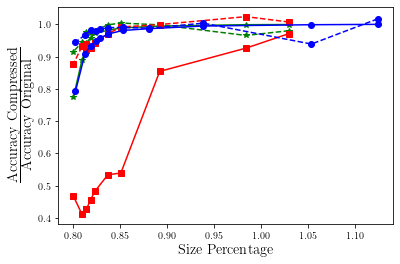

In [59]:
plt.rcParams.update({"text.usetex": True})
plt.plot(np.array(size_with_layer_2)/initial_size, acc_DLR_layer2/origAccuracy, 'g-*' )
plt.plot(np.array(size_with_layer_2)/initial_size, acc_DLR_finetuned_layer2/origAccuracy, 'g--*' )

plt.plot(np.array(size_with_layer_2)/initial_size, acc_LR_layer2/origAccuracy, 'r-s' )
plt.plot(np.array(size_with_layer_2)/initial_size, acc_LR_finetuned_layer2/origAccuracy, 'r--s' )

plt.plot(np.array(nettrimm_size_with_layer_2)/initial_size, acc_nettrim_layer2/origAccuracy, 'b-o' )
plt.plot(np.array(nettrimm_size_with_layer_2)/initial_size, acc_netrim_finetuned_layer2/origAccuracy, 'b--o' )

plt.xlabel(r'$\textrm{Size Percentage}$', fontsize='x-large')
plt.ylabel(r'$\frac{\textrm{Accuracy Compressed}}{\textrm{Accuracy Original}}$',fontsize='x-large') 
plt.savefig('Figures/MNIST_layer2_Ntr_512_N_approx_512_full_finetune.pdf')

In [60]:
# DLR for both the layers 
U_dict_layer1 = np.load('approx_matrices/DLR_layer_1_Run2_N_512.npy',allow_pickle=True).item()
U_dict_layer2 = np.load('approx_matrices/DLR_layer_2_Run2_N_512.npy',allow_pickle=True).item()
acc_DLR = []
acc_DLR_finetuned = []
ranks = []
for key1, key2, rank1, rank2 in zip(U_dict_layer1.keys(), U_dict_layer2.keys(), ranks_layer1, ranks_layer2):
    
    W1 = U_dict_layer1[key1]
    [U1,S1,V1] = np.linalg.svd(W1)
    U1 = np.dot(U1[:,:rank1], np.diag(S1[:rank1]))
    V1 = V1[:rank1, :]
    
    W2 = U_dict_layer2[key2]
    [U2,S2,V2] = np.linalg.svd(W2)
    U2 = np.dot(U2[:,:rank2], np.diag(S2[:rank2]))
    V2 = V2[:rank2, :]
                            
    loadedModel = keras.models.load_model('Lenet_Mnist_Run2')
    

    bias1 = getLayerBias(loadedModel, 5)
    low_rank_layer1 = lowrankLayer(W1.shape[0], W1.shape[1], rank1)
    dum = low_rank_layer1(tf.ones(shape=(1, W1.shape[0])))     # for proper initialization   
    low_rank_layer1.set_weights([U1,V1,bias1])
    
    bias2 = getLayerBias(loadedModel, 6)
    low_rank_layer2 = lowrankLayer(W2.shape[0], W2.shape[1], rank2)
    dum = low_rank_layer2(tf.ones(shape=(1, W2.shape[0])))     # for proper initialization   
    low_rank_layer2.set_weights([U2,V2,bias2])
                      
    new_layer_list = [keras.Input(shape=(28,28,1))]
    for i,layer in enumerate(loadedModel.layers):
        if i == 5:
            new_layer_list.append(low_rank_layer1)
        elif i == 6:
            new_layer_list.append(low_rank_layer2)
        else:
            #layer.trainable = False
            new_layer_list.append(layer)
                            
    LenetModel_Approx = keras.Sequential(new_layer_list)
    LenetModel_Approx.compile(optimizer=keras.optimizers.Adam(learning_rate = 1e-3), 
                   loss=keras.losses.SparseCategoricalCrossentropy(), 
                   metrics=[keras.metrics.SparseCategoricalAccuracy()])
    
    loss, acc = LenetModel_Approx.evaluate(test_images, test_labels, batch_size=128)
    acc_DLR.append(acc)
                            
    LenetModel_Approx.fit(train_images, train_labels, batch_size=64, epochs=1, validation_data=(val_images, val_labels))
    loss, acc = LenetModel_Approx.evaluate(test_images, test_labels, batch_size=128)
    acc_DLR_finetuned.append(acc)     

acc_DLR_combined= np.array(acc_DLR)
acc_DLR_finetuned_combined = np.array(acc_DLR_finetuned)

79/79 [==============================] - 0s 1ms/step - loss: 0.7396 - sparse_categorical_accuracy: 0.7651


In [61]:
size_with_combined = []
for rank1, rank2 in zip(ranks_layer1, ranks_layer2):
    size =  6*5*5*1 + 6  + 16*5*5*6 + 16 +  (256 + 120)*rank1 + 120 +  (120+ 84)*rank2 + 84 +  84*10 +10
    size_with_combined.append(size)

In [62]:
# LR for both the layers 
U_dict_layer1 = np.load('approx_matrices/DLR_layer_1_Run2_N_512.npy', allow_pickle=True).item()
U_dict_layer2 = np.load('approx_matrices/DLR_layer_2_Run2_N_512.npy', allow_pickle=True).item()
acc_LR = []
acc_LR_finetuned = []
ranks = []
for rank1, rank2 in zip(ranks_layer1, ranks_layer2):
    
    loadedModel = keras.models.load_model('Lenet_Mnist_Run2')
    W1 = loadedModel.get_layer(index=5).get_weights()[0]
    bias1  = loadedModel.get_layer(index=5).get_weights()[1]
    [U1,S1,V1] = np.linalg.svd(W1)
    U1 = np.dot(U1[:,:rank1], np.diag(S1[:rank1]))
    V1 = V1[:rank1, :]
    
    W2 = loadedModel.get_layer(index=6).get_weights()[0]
    bias2  = loadedModel.get_layer(index=6).get_weights()[1]
    [U2,S2,V2] = np.linalg.svd(W2)
    U2 = np.dot(U2[:,:rank2], np.diag(S2[:rank2]))
    V2 = V2[:rank2, :]
                            
 
    low_rank_layer1 = lowrankLayer(W1.shape[0], W1.shape[1], rank1)
    dum = low_rank_layer1(tf.ones(shape=(1, W1.shape[0])))     # for proper initialization   
    low_rank_layer1.set_weights([U1,V1,bias1])
    
    bias2 = getLayerBias(loadedModel, 6)
    low_rank_layer2 = lowrankLayer(W2.shape[0], W2.shape[1], rank2)
    dum = low_rank_layer2(tf.ones(shape=(1, W2.shape[0])))     # for proper initialization   
    low_rank_layer2.set_weights([U2,V2,bias2])
                      
    new_layer_list = [keras.Input(shape=(28,28,1))]
    for i,layer in enumerate(loadedModel.layers):
        if i == 5:
            new_layer_list.append(low_rank_layer1)
        elif i == 6:
            new_layer_list.append(low_rank_layer2)
        else:
            #layer.trainable = False
            new_layer_list.append(layer)
                            
    LenetModel_Approx = keras.Sequential(new_layer_list)
    LenetModel_Approx.compile(optimizer=keras.optimizers.Adam(learning_rate = 1e-3), 
                   loss=keras.losses.SparseCategoricalCrossentropy(), 
                   metrics=[keras.metrics.SparseCategoricalAccuracy()])
    
    loss, acc = LenetModel_Approx.evaluate(test_images, test_labels, batch_size=128)
    acc_LR.append(acc)
                            
    LenetModel_Approx.fit(train_images, train_labels, batch_size=64, epochs=2, validation_data=(val_images, val_labels))
    loss, acc = LenetModel_Approx.evaluate(test_images, test_labels, batch_size=128)
    acc_LR_finetuned.append(acc)     

acc_LR_combined = np.array(acc_LR)
acc_LR_finetuned_combined = np.array(acc_LR_finetuned)

79/79 [==============================] - 0s 2ms/step - loss: 0.6001 - sparse_categorical_accuracy: 0.8147
Epoch 1/2
8/8 [==============================] - 0s 28ms/step - loss: 0.4059 - sparse_categorical_accuracy: 0.8516 - val_loss: 0.4730 - val_sparse_categorical_accuracy: 0.8504
Epoch 2/2
79/79 [==============================] - 0s 1ms/step - loss: 0.7305 - sparse_categorical_accuracy: 0.7636
Epoch 1/2
8/8 [==============================] - 0s 26ms/step - loss: 0.4208 - sparse_categorical_accuracy: 0.8594 - val_loss: 0.4795 - val_sparse_categorical_accuracy: 0.8457
Epoch 2/2
79/79 [==============================] - 0s 1ms/step - loss: 0.9393 - sparse_categorical_accuracy: 0.6924
Epoch 1/2
8/8 [==============================] - 0s 27ms/step - loss: 0.5298 - sparse_categorical_accuracy: 0.8145 - val_loss: 0.5596 - val_sparse_categorical_accuracy: 0.8172
Epoch 2/2
79/79 [==============================] - 0s 1ms/step - loss: 1.9330 - sparse_categorical_accuracy: 0.3724
Epoch 1/2
8/8 [===

In [63]:
#nettrim Layer 2
U_dict_layer1 = np.load('approx_matrices/net_trim_layer_1_Run2_N_512.npy', allow_pickle=True).item()
U_dict_layer2 = np.load('approx_matrices/net_trim_layer_2_Run2_N_512.npy', allow_pickle=True).item()
thr = 0.0001
acc_nettrim = []
acc_nettrim_finetuned = []
nnzs_1 = []
nnzs_2 = []
for eps1, eps2 in zip(U_dict_layer1.keys(), U_dict_layer2.keys()):
    
    W = U_dict_layer1[eps1]
    W[np.abs(W)<=thr] = 0.0
    M = np.ones_like(W, dtype="float32")
    M[np.abs(W)<=thr] = 0.0
    W = W.astype("float32")
    M = M.astype("float32")
    nnz = np.count_nonzero(W)
    nnzs_1.append(nnz)
                                
    loadedModel = keras.models.load_model('Lenet_Mnist_Run2')
    bias = getLayerBias(loadedModel, 5)
    
    sparseLayer1 = sparseLayerlocal(n_input=W.shape[0], n_output=W.shape[1], Wip=W, Mip=M, bias_ip=bias)
    
    W = U_dict_layer2[eps2]
    W[np.abs(W)<=thr] = 0.0
    M = np.ones_like(W, dtype="float32")
    M[np.abs(W)<=thr] = 0.0
    W = W.astype("float32")
    M = M.astype("float32")
    nnz = np.count_nonzero(W)
    nnzs_2.append(nnz)
                                
    loadedModel = keras.models.load_model('Lenet_Mnist_Run2')
    bias = getLayerBias(loadedModel, 6)
    
    sparseLayer2 = sparseLayerlocal(n_input=W.shape[0], n_output=W.shape[1], Wip=W, Mip=M, bias_ip=bias)
    
    
                      
    new_layer_list = [keras.Input(shape=(28,28,1))]
    for i,layer in enumerate(loadedModel.layers):
        if i == 5:
            new_layer_list.append(sparseLayer1)
        elif i == 6: 
            new_layer_list.append(sparseLayer2)
        else:
            #layer.trainable = False
            new_layer_list.append(layer)
                            
    LenetModel_Approx = keras.Sequential(new_layer_list)
    LenetModel_Approx.compile(optimizer=keras.optimizers.Adam(learning_rate = 1e-3), 
                   loss=keras.losses.SparseCategoricalCrossentropy(), 
                   metrics=[keras.metrics.SparseCategoricalAccuracy()])
    
    loss, acc = LenetModel_Approx.evaluate(test_images, test_labels, batch_size=128)
    acc_nettrim.append(acc)
                            
    LenetModel_Approx.fit(train_images, train_labels, batch_size=64, epochs=1, validation_data=(val_images, val_labels))
    loss, acc = LenetModel_Approx.evaluate(test_images, test_labels, batch_size=128)
    acc_nettrim_finetuned.append(acc)     

acc_nettrim_combined = np.array(acc_nettrim)
acc_nettrim_finetuned_combined= np.array(acc_nettrim_finetuned)

79/79 [==============================] - 0s 1ms/step - loss: 0.7866 - sparse_categorical_accuracy: 0.7559


In [64]:
size_nettrim_combined = []
for nnz_1, nnz_2 in zip(nnzs_1, nnzs_2):
    #size =  6*5*5*1 + 6  + 16*5*5*6 + 16 +  nnz_1 + nnz_1*np.log2(256*120)/32 + 120 + nnz_2 + nnz_2*np.log2(120*84)/32 + 84 +  84*10 +10
    size =  6*5*5*1 + 6  + 16*5*5*6 + 16 +  3*nnz_1  + 120 + 3*nnz_2  + 84 +  84*10 +10 # for csr format
    size_nettrim_combined.append(size)

Text(0, 0.5, '$\\frac{\\textrm{Accuracy Compressed}}{\\textrm{Accuracy Original}}$')

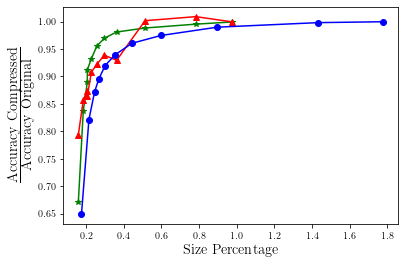

In [70]:
plt.rcParams.update({"text.usetex": True})
plt.plot(np.array(size_with_combined)/initial_size, acc_DLR_combined/origAccuracy, 'g-*' )
#plt.plot(np.array(size_with_combined)/initial_size, acc_DLR_finetuned_combined/origAccuracy, 'g--*' )

#plt.plot(np.array(size_with_combined)/initial_size, acc_LR_combined/origAccuracy, 'r-s' )
plt.plot(np.array(size_with_combined)/initial_size, acc_LR_finetuned_combined/origAccuracy, 'r-^' )

plt.plot(np.array(size_nettrim_combined)/initial_size, acc_nettrim_combined/origAccuracy, 'b-o' )
#plt.plot(np.array(size_nettrim_combined)/initial_size, acc_nettrim_finetuned_combined/origAccuracy, 'b--o' )

plt.xlabel(r'$\textrm{Size Percentage}$', fontsize='x-large')
plt.ylabel(r'$\frac{\textrm{Accuracy Compressed}}{\textrm{Accuracy Original}}$',fontsize='x-large') 
#plt.savefig('Figures/MNIST_combined_Ntr_512_N_approx_512_full_finetune.pdf')

In [ ]:
sum_x ||RelU(UVx+b) - Relu(Wx+b)||_2^2 vs. U,V from low rank of W, then finetune the entire model.